# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

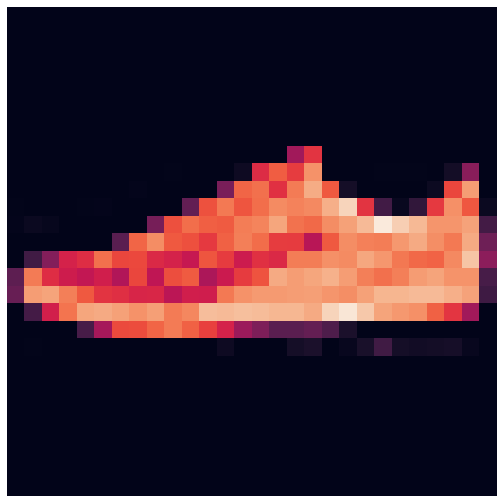

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

In [6]:
uniq_ind = np.unique(y,return_index=True)[1]

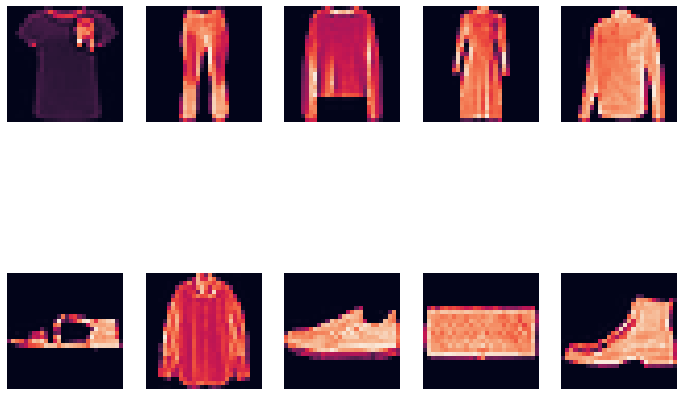

In [7]:
for i in range(len(uniq_ind)):
    plt.subplot(2,5,i+1)
    plt.imshow(X[uniq_ind[i]].reshape(28,28,1))
    plt.axis("off")

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [8]:
# Посчитаем количество уникальных эелементов
for i in range(len(np.unique(y))):
    print(i+1, str(np.unique(y, return_counts=True)[1][i]))

1 93
2 102
3 95
4 121
5 96
6 98
7 101
8 79
9 109
10 106


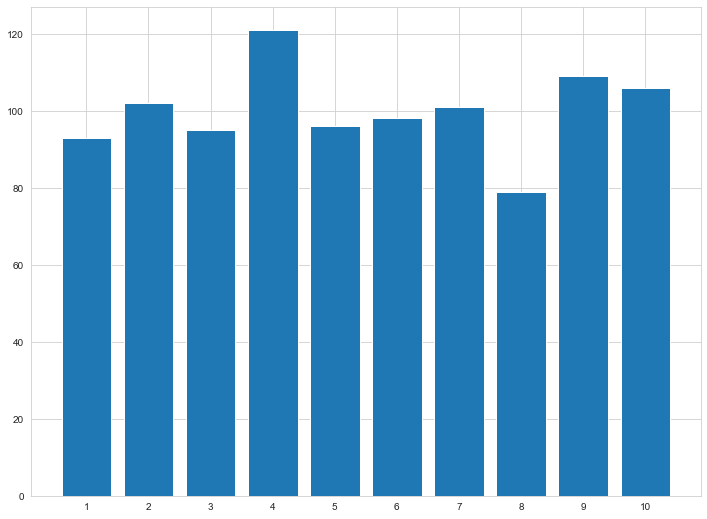

In [9]:
# Можно их нарисововать
plt.bar(x = [i for i in range(1,11)], height=np.unique(y, return_counts=True)[1])
plt.xticks([i for i in range(1,11)]);

In [10]:
# Посмотрим, есть ли пропущенные значение в Х. Если сумма по строке > 0, то какие-то пиксели должны быть
print(np.all(np.sum(X, axis = 1))) # Если True, то нет пропущенных
print(np.sum(X, axis = 1).min())

True
9517.0


In [11]:
# Поменяем object -> int
y = y.astype('int')

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [139]:
y_test.shape, y_train.shape

((250,), (750,))

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

__Binary train__

In [140]:
binary_train_y = y_train[(y_train == 1) | (y_train==0)]

In [141]:
binary_train_X = X_train[np.where((y_train == 0)|(y_train==1))[0]]

In [142]:
binary_train_X.shape, binary_train_y.shape

((141, 784), (141,))

__Binary test__

In [143]:
binary_test_y = y_test[(y_test == 1) | (y_test==0)]

In [144]:
binary_test_X = X_test[np.where((y_test == 0)|(y_test == 1))[0]]

In [145]:
binary_test_X.shape, binary_test_y.shape

((54, 784), (54,))

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [146]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, но можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [155]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [156]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [157]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [158]:
# Как-то я похоже не так без циклов реализовал.
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

51.3 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.48 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.8 ms ± 473 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [159]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)
np.sum(prediction == binary_test_y)/binary_test_y.size

0.9814814814814815

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [22]:
# TODO: binary_classification_metrics in metrics.py

Не совсем понял как __избежать численной нестабильности__. Прописать try, except? 

In [160]:
tests = binary_classification_metrics(prediction, binary_test_y)
print(f'accuracy: {tests[0]}')
print(f'precision: {tests[1]}')
print(f'recall: {tests[2]}')
print(f'f1_score: {tests[3]}')

accuracy: 0.9814814814814815
precision: 0.9615384615384616
recall: 1.0
f1_score: 0.9803921568627451


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

__Проверка__ полученных данных на sklearn

In [161]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [162]:
cls = KNeighborsClassifier(n_neighbors=20, p=1, metric='manhattan')
cls.fit(binary_train_X, binary_train_y)

KNeighborsClassifier(metric='manhattan', n_neighbors=20, p=1)

In [145]:
pred = cls.predict(binary_test_X)

In [163]:
confusion_matrix(binary_test_y, pred)

array([[28,  1],
       [ 0, 25]])

In [164]:
print(f'Accuracy from sklearn: {accuracy_score(binary_test_y, pred)}')
print(f'Precision from sklearn: {precision_score(binary_test_y, pred)}')
print(f'Recall from sklearn: {recall_score(binary_test_y, pred)}')
print(f'f1_score from sklearn: {f1_score(binary_test_y, pred)}')
print('_______________')
print('The same')

Accuracy from sklearn: 0.9814814814814815
Precision from sklearn: 0.9615384615384616
Recall from sklearn: 1.0
f1_score from sklearn: 0.9803921568627451
_______________
The same


<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `find_best_k` прямо в ноутбуке.

In [165]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    metrics_test = []
    metrics_train = []
    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        prediction_test = knn_classifier.predict(X_test)
        prediction_train = knn_classifier.predict(X_train)
        print(str(k) + 'k for test'+ ': ' + str(metric(prediction_test, y_test)))
        print(str(k) + 'k for train'+ ': ' + str(metric(prediction_train, y_train)))
        print()
        metrics_test.append(metric(prediction_test, y_test))
        metrics_train.append(metric(prediction_train, y_train))
    return metrics_test, metrics_train

In [184]:
params = [1, 2, 4, 5, 8, 10, 30]
print('f_1_score score for test data with different k: ')
print()
test_metrics, train_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)


f_1_score score for test data with different k: 

1k for test: 0.9814814814814815
1k for train: 1.0

2k for test: 0.9814814814814815
2k for train: 1.0

4k for test: 0.9814814814814815
4k for train: 0.9929078014184397

5k for test: 0.9814814814814815
5k for train: 0.9787234042553191

8k for test: 0.9629629629629629
8k for train: 0.9858156028368794

10k for test: 0.9629629629629629
10k for train: 0.9858156028368794

30k for test: 0.9629629629629629
30k for train: 0.9432624113475178



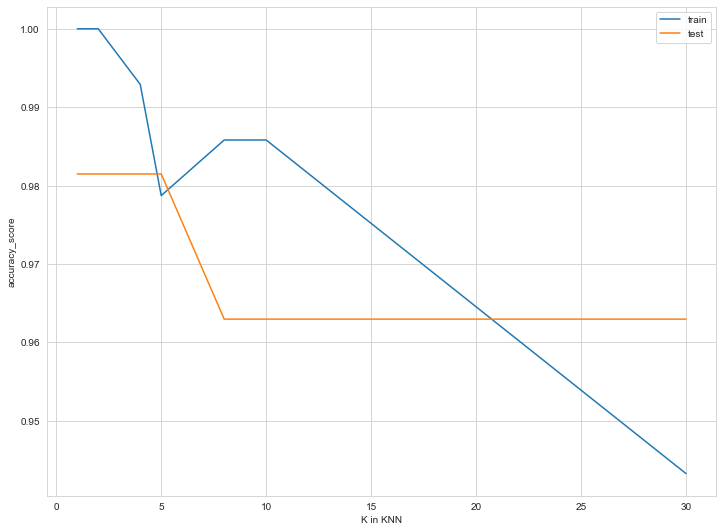

In [185]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("accuracy_score");

k ~ __5__. 

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассовая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

Сделаем сразу проверку на sklearn:

In [186]:
cls = KNeighborsClassifier(n_neighbors=1, p=1, metric='manhattan')
cls.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=1)

In [187]:
pred = cls.predict(X_test)

In [188]:
np.sum(pred == y_test)

190

In [189]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

In [190]:
# Свой алгоритм работает также как и sklern'овский
np.all(predictions == pred)

True

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [191]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.7600000000000001

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [193]:
params = [1, 2, 4, 5, 8, 10, 30, 50]
print('Accuracy score for test data with different k using multiple classification: ')
print()
test_metrics, train_metrics = find_best_k(X_train, y_train, X_test, y_test, params, multiclass_accuracy)

Accuracy score for test data with different k using multiple classification: 

1k for test: 0.7600000000000001
1k for train: 1.0000000000000002

2k for test: 0.7480000000000001
2k for train: 0.8973333333333335

4k for test: 0.7840000000000001
4k for train: 0.8506666666666668

5k for test: 0.7720000000000001
5k for train: 0.8346666666666668

8k for test: 0.7800000000000001
8k for train: 0.8280000000000001

10k for test: 0.7760000000000001
10k for train: 0.8146666666666668

30k for test: 0.7040000000000001
30k for train: 0.7560000000000002

50k for test: 0.648
50k for train: 0.7306666666666668



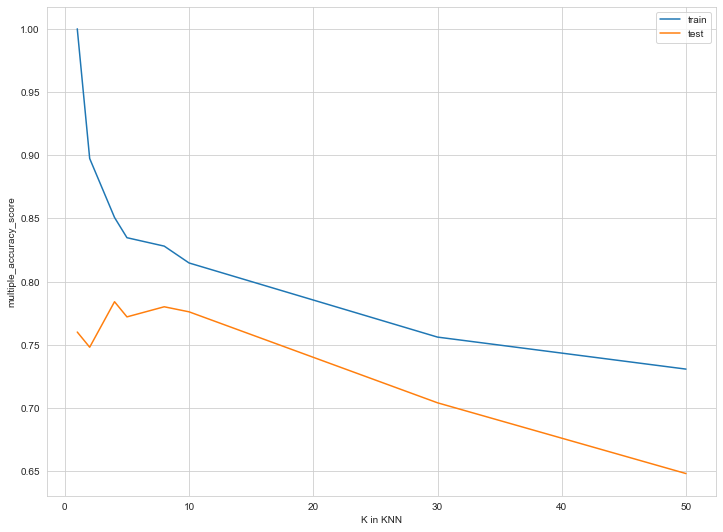

In [194]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("multiple_accuracy_score");

k ~ __7-9__

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [197]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [198]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [199]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [200]:
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer

In [201]:
X.shape

(442, 10)

In [202]:
X.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

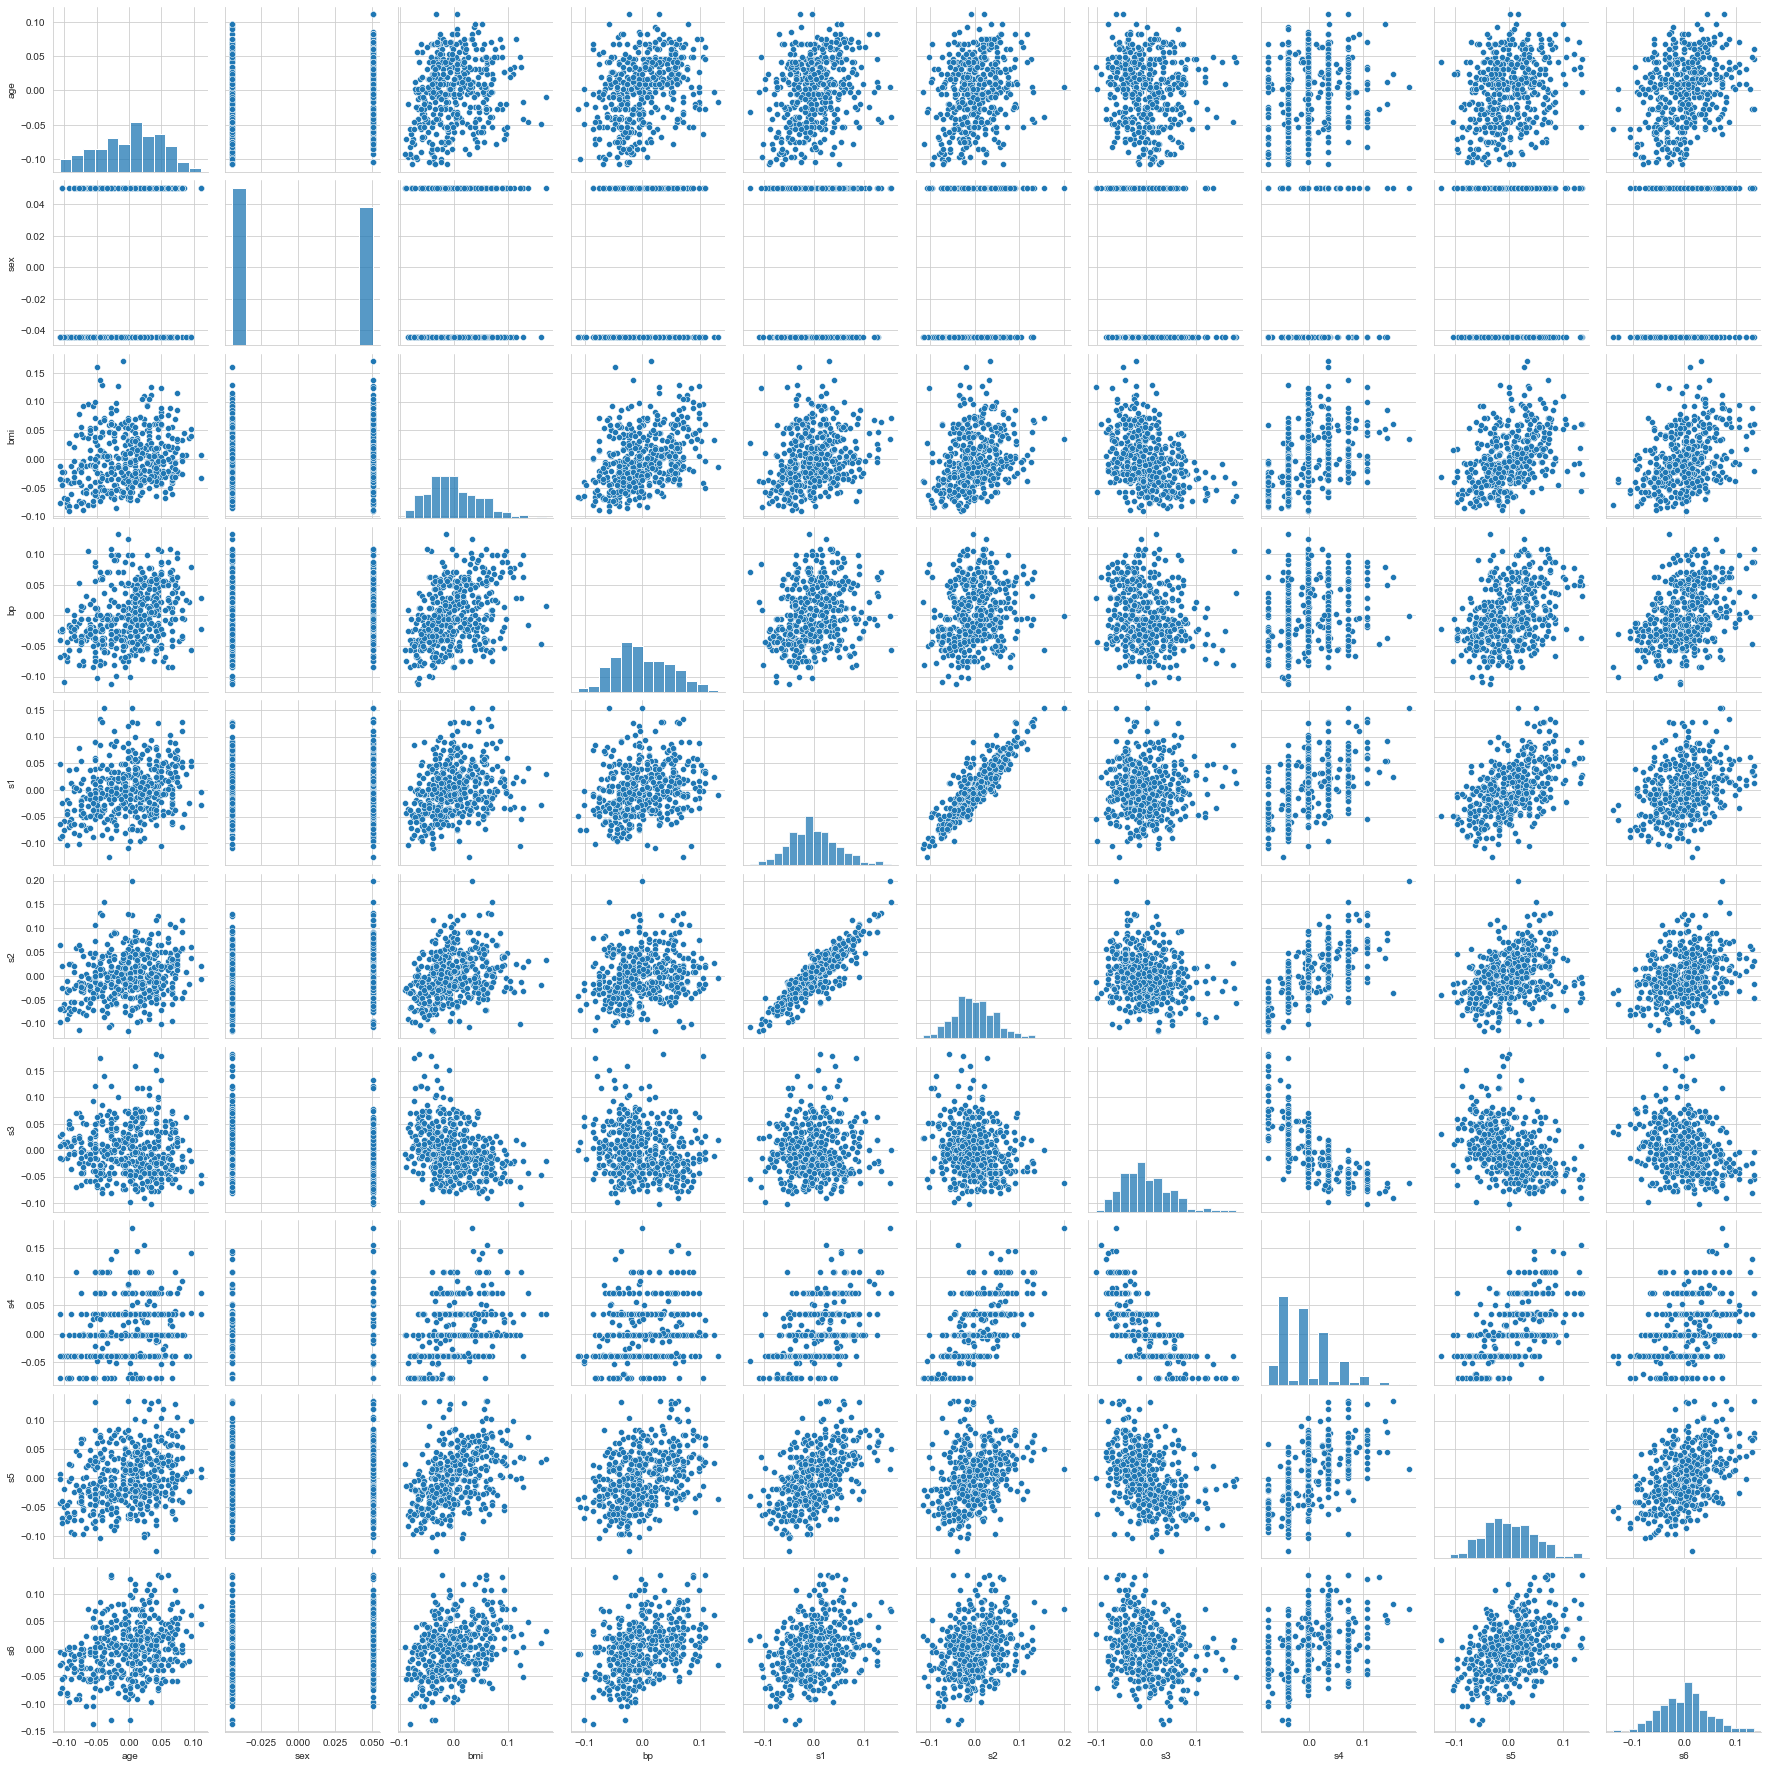

In [203]:
# Думал, что это будет более информативно. Хотя оставлю, так как все равно можно какую-то инфу извлечь полезную
sns.pairplot(X,diag_kind="hist");

In [204]:
# Вообще не обязательно менять переменную sex, но так для читаемости лучше и так как признак бинарный можно оставить в 1 колонке
X.sex = X.sex.apply(lambda x: 1 if x > 0 else 0)

Make __pipeline__

In [205]:
X.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [206]:
num_cols = ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
cat_col = 'sex'

In [207]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols)])

knn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn_pipeline", KNeighborsRegressor(n_neighbors=10, n_jobs=-1))
])

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.2)

In [209]:
knn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['age', 'bmi', 'bp', 's1',
                                                   's2', 's3', 's4', 's5',
                                                   's6'])])),
                ('knn_pipeline',
                 KNeighborsRegressor(n_jobs=-1, n_neighbors=10))])

При k = 10

In [210]:
regression_prediction = knn_pipeline.predict(X_test)

In [211]:
regression_prediction

array([249.6, 201.9, 173.8,  95. , 186.9, 218.6, 113.2, 210.2, 157.4,
       213.3, 144.9, 189.1, 130.9,  96.7, 251.2, 104.9, 125.8,  89.5,
        94.7, 208.6, 158.6,  98.4, 158. , 109.4, 185.3, 167.6, 106.6,
        82.4, 184.5, 156.2, 187.9,  69. , 124. , 176.8, 118.7, 180.1,
       175.9, 180.7, 114.9, 203.5, 126.5, 167.2, 128. , 142.6, 171.3,
        97.9, 101.1, 101.8, 121.4, 212.3, 144.3,  81.6, 163.7, 127.8,
       233.6, 205.2, 185.5, 100.5, 110.9, 182.2, 165.1, 131.9, 121.9,
       127.9, 246.3, 101.5,  80.2, 257. , 184. ,  91.9,  94.2, 151.7,
        90.6, 107.6, 114.2, 172.8, 139.1, 185.8, 234. , 175.5, 113.1,
       225.3,  82.7, 210.9, 110. ,  85. , 102. , 158.4, 104.2])

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [212]:
from metrics import mae as my_mae
from metrics import mse as my_mse
from metrics import r_squared as my_r_squared

Посомтрим на метрики регрессии при k=10

In [213]:
my_mae(regression_prediction, y_test)

4087.500000000001

In [214]:
my_mse(regression_prediction, y_test)

2388.912471910113

In [215]:
my_r_squared(regression_prediction, y_test)

-4.6629367034256575e-15

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [216]:
from metrics import r_squared, mse, mae

Метрики из sklearn выдают такие же значения как и мои

In [217]:
mae(regression_prediction,y_test)

4087.500000000001

In [218]:
mse(regression_prediction,y_test)

2388.912471910113

In [219]:
r_squared(regression_prediction,y_test)

-4.6629367034256575e-15

In [224]:
def best_k_regression(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KNNREgression
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    metrics_test = []
    metrics_train = []
    for k in params:
        preprocessor = ColumnTransformer(transformers=[
        ("scaler", StandardScaler(), num_cols)])

        knn_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("knn_pipeline", KNeighborsRegressor(n_neighbors=k, n_jobs=-1))
        ])
        knn_pipeline.fit(X_train,y_train)
        regression_prediction_test = knn_pipeline.predict(X_test)
        prediction_train = knn_pipeline.predict(X_train)
        print(str(k) + 'k for test'+ ': ' + str(metric(regression_prediction_test, y_test)))
        print(str(k) + 'k for train'+ ': ' + str(metric(prediction_train, y_train)))
        print()
        metrics_test.append(metric(regression_prediction_test, y_test))
        metrics_train.append(metric(prediction_train, y_train))
    return metrics_test, metrics_train

In [225]:
params = [1, 2, 4, 5, 8, 10, 30]
print('MSE score for test data with different k: ')
print()
test_metrics, train_metrics = best_k_regression(X_train, y_train, X_test, y_test, params, mse)

MSE score for test data with different k: 

1k for test: 56.640449438202246
1k for train: 0.0

2k for test: 2180.2275280898875
2k for train: 1761.2811614730879

4k for test: 3561.449438202247
4k for train: 3034.631728045326

5k for test: 2901.8791011235953
5k for train: 3168.605552407933

8k for test: 2089.624297752809
8k for train: 1684.5149167847026

10k for test: 2388.912471910113
10k for train: 2564.7372521246457

30k for test: 5353.573832709113
30k for train: 8958.165262826567



Чем меньше MSE, тем лучше. Можно выбрать для модели __k=9__

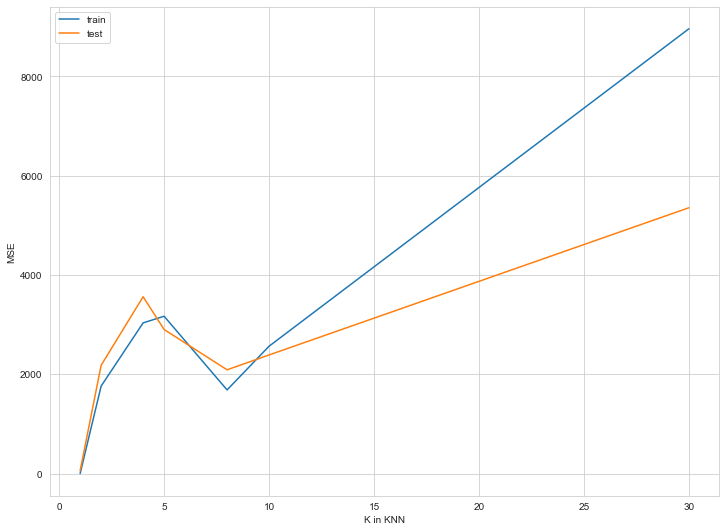

In [226]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("MSE");

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

**Ваши мысли:**

Если в общем, то было очень хард и очень интересно. Ну я потратил суммарно часов 30. Из них часов 20 реально трудился. Алгоритм действительно простой, но от этого и хуже. Боюсь представить, как буду решать задания со сложной математикой. Даже регрессия пугает уже (еще не смотрел). А так пока что очень воодушевлен и получаю удовольствие от обучения! ☺️ 